In [1]:
from torchvision.datasets import MNIST

# get the MNIST dataset
dataset = MNIST("./", download=True)
# each element is an image of shape 28x28
print(dataset[0][1])
print(dataset.data[0].shape)
display(dataset[0][0])

# we keep only the zeros and ones for binary classification
zeros_and_ones = [i for i, d in enumerate(dataset) if d[1] in (0,1)]
# for this small example 100 data should be enough
data = dataset.data[zeros_and_ones][:100]
targets = dataset.targets[zeros_and_ones][:100]
images = [dataset[i][0] for i in zeros_and_ones][:100]
print(targets[0])
display(images[0])

5
torch.Size([28, 28])


tensor(0)


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# we can define a classical image encoder
# composed of a combination of convolutional, pooling and linear layers
class ImageEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 3, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(3 * 13 * 13, 32)
        self.fc3 = nn.Linear(32, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x) 
        x = F.relu(self.fc1(x))
        x = self.fc3(x)
        return x


img_encoder = ImageEncoder().double()


In [3]:
import numpy as np
from qibo import set_backend, Circuit, gates
from qibo.symbols import Z
from qibo.hamiltonians import SymbolicHamiltonian

from qiboml.models.pytorch import QuantumModel
from qiboml.models.encoding import PhaseEncoding
from qiboml.models.decoding import Expectation, Probabilities

# then we build the quantum model, that will
# act as a classification layer on top of the
# classical image encoder

# let's set the qibo global backend with the one we like,
# e.g. pytorch 
set_backend("pytorch")

# we prepare a quantum encoder to encode the 
# classical data in a quantum circuit
nqubits = 2
encoding = PhaseEncoding(nqubits=nqubits)

# we construct a trainable parametrized circuit
# that is the core of our quantum model
circuit = Circuit(nqubits)
for _ in range(5):
    for q in range(nqubits):
        circuit.add(gates.RY(q, theta=np.random.randn() * np.pi))
        circuit.add(gates.RZ(q, theta=np.random.randn() * np.pi))
    circuit.add(gates.CNOT(0,1))
circuit.draw()

# and finally we need a decoder to decode the quantum
# information and extract the classical predictions,
# for instance the expectation value calculation

# for this we need to define the observable we wish to
# measure
observable = SymbolicHamiltonian(Z(0), nqubits=nqubits)
# and then construct the expectation decoder
decoding = Expectation(nqubits=nqubits, observable=observable, analytic=True)

# we can then build the complete quantum model
q_model = QuantumModel(
    encoding,
    circuit,
    decoding
)

2024-11-19 20:07:35.829624: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-19 20:07:35.841509: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-19 20:07:35.845157: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-19 20:07:35.855091: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-19 20:07:36.540988: W tensorflow/compiler/tf2

q0: ─RY─RZ─o─RY─RZ─o─RY─RZ─o─RY─RZ─o─RY─RZ─o─
q1: ─RY─RZ─X─RY─RZ─X─RY─RZ─X─RY─RZ─X─RY─RZ─X─


In [4]:
# Since we are using an angular encoding, it is better to
# make sure that the output of the img_encoder are meaningful
# angles. To do so we can define a custom torch activation
# that rescales everything in the interval (-pi, pi)

class PiTanh(nn.Module):

    def forward(self, x):
        # we first rescale x to avoid the risk
        # of saturating the tanh too often and, thus,
        # producing always the same angle
        x = x / x.max()
        # then we just apply the tanh and rescale by pi
        return np.pi * F.tanh(x)

activation = PiTanh().double()

In [5]:
# Finally, the complete hybrid classical-quantum pipeline can
# be built by stacking the different components in a 
# torch.nn.Sequential as usual
model = nn.Sequential(
    img_encoder,
    activation,
    q_model,
)

In [6]:
# to evaluate the performance of the model we can use the
# standard binary F1 score
from torcheval.metrics.functional import binary_f1_score

# let's check how the model does before training
with torch.no_grad():
    predictions = torch.as_tensor([F.sigmoid(model(x.double().unsqueeze(0))) for x in data])
    print(binary_f1_score(predictions, targets))

tensor(0.)


Final Loss: 0.3201002721815339


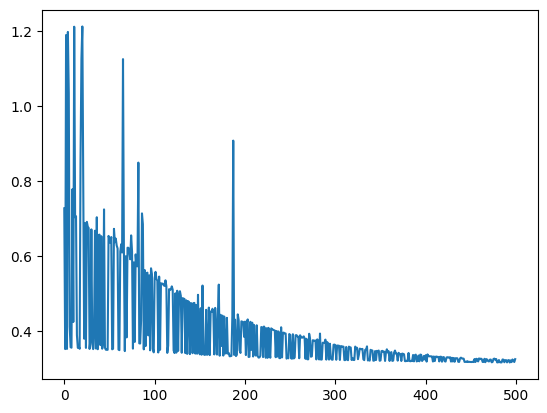

In [7]:
import matplotlib.pyplot as plt
from torch.optim import Adam

# now we can train the model as we would do
# with any other pytorch model

# let's use the torch.optim.Adam optimizer
optimizer = Adam(model.parameters())
# we are going to train for 5 epochs
losses = []
for _ in range(5):
    # reshuffle the data before each epoch
    permutation = torch.randperm(len(data))
    for x, y in zip(data[permutation], targets[permutation]):
        optimizer.zero_grad()
        # get the predictions
        out = model(x.double().unsqueeze(0))
        # calculate the loss, we can take the
        # standard binary cross entropy
        loss = F.binary_cross_entropy_with_logits(out.view(1,), y.double().view(1,))
        # backpropagate
        loss.backward()
        # update the parameters
        optimizer.step()
        losses.append(loss.item())

# we can plot the training loss over the epochs
plt.plot(range(len(losses)), losses)
# for reference we calculate the average loss obtained for
# the last 20 predictions after training
print(f"Final Loss: {sum(losses[-20:])/20}")

In [8]:
# Finally, let's double check that the F1 score has improved
with torch.no_grad():
    predictions = torch.as_tensor([F.sigmoid(model(x.double().unsqueeze(0))) for x in data])
    print(binary_f1_score(predictions, targets))

tensor(1.)
